In [15]:
import numpy as np
import sklearn.datasets
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import time
import scipy.ndimage
import skimage.transform
from random import randint

In [2]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#отображение графиков в ноутбуке
%matplotlib inline 

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg' 

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [17]:
dataset = sklearn.datasets.fetch_openml("mnist_784", return_X_y=True, as_frame=True)

In [18]:
#@title
def euclidean_distance(X, Y):
    distance = np.linalg.norm(X, axis=1)[:, None] ** 2 + \
        np.linalg.norm(Y, axis=1)[None, :] ** 2 - \
        (2.0 * X) @ Y.T
    distance[np.where((distance) < 1e-12)] = 0
    return np.sqrt(distance)


def cosine_distance(X, Y):
    # где нулевые элементы, сделаем нули
    with np.errstate(divide='ignore', invalid='ignore'):
        distance = np.divide(X @ Y.T, (
            np.linalg.norm(X, axis=1)[:, None] *
            np.linalg.norm(Y, axis=1)[None, :]
        ))
    distance[np.where(np.isnan(distance))] = 1
    distance[np.where(abs(distance) < 1e-12)] = 0
    return 1 - distance

In [19]:
#@title
class KNNClassifier:
    def __init__(self, k, strategy, metric, weights, test_block_size):
        self.strategy = strategy
        self.k = k
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size
        if strategy == 'my_own':
            self.X_train = None
            self.y_train = None
        else:
            if (strategy == 'kd_tree') | (strategy == 'ball_tree'):
                self.metric = 'euclidean'
            self.Neigh = NearestNeighbors(n_neighbors=k, metric=self.metric, algorithm=self.strategy)

    def fit(self, X, y):  # обучение strategy
        if self.strategy != "my_own":
            self.X_train = self.Neigh.fit(X, y)
            self.y_train = y
        else:
            self.X_train = X
            self.y_train = y

    def find_kneighbors(self, X, return_distance):
        if self.strategy != "my_own":
            return self.Neigh.kneighbors(X, n_neighbors=self.k, return_distance=return_distance)
        if self.metric == 'euclidean':
            matr = euclidean_distance(X, self.X_train)
        else:
            matr = cosine_distance(X, self.X_train)
        index_nearest = np.argpartition(matr, kth=self.k, axis=1)[:, :self.k]
        matr = np.take_along_axis(matr, index_nearest, axis=1)
        sorted_index = np.argsort(matr, axis=1)
        index_nearest = np.take_along_axis(index_nearest, sorted_index, axis=1)
        if not return_distance:
            return index_nearest
        matr = np.take_along_axis(matr, sorted_index, axis=1)
        return matr, index_nearest

    def predict(self, X):
        def answer_func(ouri, ourd):
            maximum = -1
            for i in set(ouri):
                t = np.sum(ourd[np.where(ouri == i)])
                if t > maximum:
                    maximum = t
                    ans = i
            return ans

        if not self.weights:
            prediction_all = np.empty(X.shape[0], dtype=int)
            distance_kneighbors = np.ones(X.shape[1])
            for j in range(
                    self.test_block_size, X.shape[0] + self.test_block_size, self.test_block_size
            ):
                index_kneighbors = self.find_kneighbors(X[j - self.test_block_size:j], False)
                prediction = np.empty(index_kneighbors.shape[0], dtype=int)
                for i in range(index_kneighbors.shape[0]):
                    prediction[i] = answer_func(self.y_train[index_kneighbors][i], distance_kneighbors)
                prediction_all[j - self.test_block_size:j] = prediction
        else:
            prediction_all = np.empty(X.shape[0], dtype=int)
            eps = 1e-5
            for j in range(
                    self.test_block_size, X.shape[0] + self.test_block_size, self.test_block_size
            ):
                distance_kneighbors, index_kneighbors = self.find_kneighbors(
                    X[j - self.test_block_size:j], True
                )
                distance_kneighbors = (distance_kneighbors + eps) ** (-1)
                prediction = np.empty(index_kneighbors.shape[0], dtype=int)
                for i in range(index_kneighbors.shape[0]):
                    prediction[i] = answer_func(self.y_train[index_kneighbors][i], distance_kneighbors[i])
                prediction_all[j - self.test_block_size:j] = prediction
        return prediction_all


In [20]:
#@title
def kfold(n, n_folds):
    '''
    Функция возвращает список длины n_folds,
     каждый элемент списка — кортеж из двух одномерных np.ndarray.
     Первый массив содержит индексы обучающей подвыборки, а второй валидационной.
    '''
    arr = np.random.choice(np.arange(n), size=n, replace=False)
    # arr = np.arange(n)
    long = (n % n_folds) * (n // n_folds + 1)
    arr1 = arr[:long]
    arr2 = arr[long:]
    arr1 = arr1.reshape(-1, n // n_folds + 1)
    arr2 = arr2.reshape(-1, n // n_folds)
    lst = []
    mask = np.ones_like(arr1)
    for i in range(arr1.shape[0]):
        mask[i] = 0
        tup = (np.concatenate((arr1[np.where(mask == 1)], arr2), axis=None), arr1[i])
        mask[i] = 1
        lst.append(tup)
    mask = np.ones_like(arr2)
    for i in range(arr2.shape[0]):
        mask[i] = 0
        tup = (np.concatenate((arr2[np.where(mask == 1)], arr1), axis=None), arr2[i])
        mask[i] = 1
        lst.append(tup)
    return lst


def knn_cross_val_score(X, y, k_list, score, cv=None, **kwargs):
    if cv is not None:
        n_folds = len(cv)
    else:
        n_folds = 3
        cv = kfold(len(X), n_folds)
    first, second = zip(*cv)
    KNN = KNNClassifier(k_list[-1], **kwargs)
    d = dict.fromkeys(k_list)
    for i in k_list:
        d[i] = np.empty(n_folds)
    for i in range(n_folds):
        KNN.fit(X[first[i]], y[first[i]])
        cls = y[first[i]]
        if not KNN.weights:
            distance_kneighbors = np.ones((len(y[second[i]]), k_list[-1]))
            index_kneighbors = KNN.find_kneighbors(X[second[i]], False)
        else:
            distance_kneighbors, index_kneighbors = KNN.find_kneighbors(X[second[i]], True)
            eps = 1e-5
            distance_kneighbors = (distance_kneighbors + eps) ** (-1)
        predict = np.zeros((second[i].shape[0], len(k_list)))
        for s in range(second[i].shape[0]):
            lst = dict()
            jj = -1
            for j in range(k_list[-1]):
                if cls[index_kneighbors[s][j]] in lst:
                    lst[cls[index_kneighbors[s][j]]] += distance_kneighbors[s][j]
                else:
                    lst[cls[index_kneighbors[s][j]]] = distance_kneighbors[s][j]
                if j + 1 in k_list:
                    jj += 1
                    predict[s][jj] = max(lst, key=lst.get)
        if score != None:
            num_true_predict = np.sum(predict == y[second[i]][:, None], axis=0)
            num_all_predict = len(predict)
            num_true_predict = num_true_predict / num_all_predict
            for j, k in enumerate(k_list):
                d[k][i] = num_true_predict[j]
    return d


In [21]:
X = dataset[0].to_numpy()
y = dataset[1].to_numpy().astype(int)
X, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([5, 0, 4, ..., 4, 5, 6]))

In [22]:
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]
y_test

array([7, 2, 1, ..., 4, 5, 6])

Измерьте для каждого алгоритма поиска ('kd_tree', 'ball_tree', 'brute' и 'my_own') время нахождения 5 ближайших соседей для каждого объекта тестовой выборки по евклидовой метрике.
 Выберите подмножество признаков, по которому будет считаться расстояние, размера 10, 20, 100 (подмножество признаков выбирается один раз для всех объектов, случайно).

In [ ]:
#@title
alg = dict.fromkeys(['kd_tree', 'ball_tree', 'brute', 'my_own'])
for i in alg:
    alg[i] = np.zeros(3)

In [ ]:
#@title
from random import randint
k_n = 5
ii = 0
for i in [10, 20, 100]:
    attributes = np.random.choice(np.arange(X_test.shape[1]), size=i, replace=False)
    # attributes = np.random.randint(0, X_test.shape[1], i)
    X_train_part = X_train[:, attributes]
    X_test_part = X_test[:, attributes]
    for j in ['kd_tree', 'ball_tree', 'brute', 'my_own']:
        classifier = KNNClassifier(k=k_n, strategy=j, metric='euclidean', weights=False, test_block_size=X_test_part.shape[0])
        classifier.fit(X_train_part, y_train)
        start_time = time.time()
        classifier.find_kneighbors(X_test_part, False)
        ans = time.time() - start_time
        alg[j][ii] = ans
    ii += 1

In [ ]:
#@title
alg

In [ ]:
#@title
alg = dict.fromkeys(['kd_tree', 'ball_tree', 'brute', 'my_own'])
for i in alg:
    alg[i] = np.zeros(40)

In [ ]:
#@title
k_n = 5
ii = 0
for i in range(4, 61, 2):
  attributes = np.random.choice(np.arange(X_test.shape[1]), size=i, replace=False)
  X_train_part = X_train[:, attributes]
  X_test_part = X_test[:, attributes]
  for j in ['kd_tree', 'ball_tree', 'brute', 'my_own']:
      classifier = KNNClassifier(k=k_n, strategy=j, metric='euclidean', weights=False, test_block_size=X_test_part.shape[0])
      classifier.fit(X_train_part, y_train)
      start_time = time.time()
      classifier.find_kneighbors(X_test_part, False)
      ans = time.time() - start_time
      alg[j][ii] = ans
  ii += 1

In [ ]:
alg

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Зависимость времени работы от числа признаков', color = 'r', fontsize=20)
plt.xlabel('Число признаков', color = 'r', fontsize=18)
plt.ylabel('Время работы, с ', color = 'r', fontsize=18)

neigh = np.arange(4, 61, 2)
plt.plot(neigh, alg['kd_tree'][:29], color='darkcyan', linewidth = 3,  marker = 'X', markersize = 7, label='kd_tree')
plt.plot(neigh, alg['ball_tree'][:29], color='darkorange', linewidth = 3, marker = 's', markersize = 7, label='ball_tree')
plt.plot(neigh, alg['brute'][:29], color='indigo', linewidth = 3, marker = '^', markersize = 7, label='brute')
plt.plot(neigh, alg['my_own'][:29], color='darkblue', linewidth = 3, marker = 'o', markersize = 7, label='my_own')

plt.xticks(np.arange(4, 61, 2))
plt.yticks(np.arange(0, 61, 5))

plt.grid(which='major', color = 'grey', linewidth = 0.5)
ax.legend(title = 'Используемый метод', title_fontsize=15, fontsize=13)

plt.show()
fig.savefig("TASK1 PRAC FIGURE 0 time work.pdf", bbox_inches = 'tight')

Оцените по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) и время работы k ближайших соседей в зависимости от следующих факторов:

(a) k от 1 до 10 (только влияние на точность).

(b) Используется евклидова или косинусная метрика.

In [ ]:
accurateness = dict.fromkeys(['euclidean', 'cosine'])

In [ ]:
time_work = dict.fromkeys(['euclidean', 'cosine'])

In [ ]:
folds = 3
k = list(range(1, 11))
for i in ['euclidean', 'cosine']:
    start_time = time.time()
    ans = knn_cross_val_score(X_train, y_train, k_list=k, score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': i, 'weights': False, 'test_block_size': 1000})
    t = time.time() - start_time
    accurateness[i] = ans
    time_work[i] = t

In [ ]:
accurateness

{'euclidean': {1: array([0.96895, 0.96675, 0.9667 ]),
  2: array([0.96895, 0.96675, 0.9667 ]),
  3: array([0.97075, 0.9691 , 0.96825]),
  4: array([0.97095, 0.9698 , 0.97015]),
  5: array([0.9692 , 0.96815, 0.9688 ]),
  6: array([0.9704 , 0.96815, 0.9692 ]),
  7: array([0.96705, 0.9659 , 0.9671 ]),
  8: array([0.9676 , 0.96645, 0.96775]),
  9: array([0.9651, 0.9644, 0.9656]),
  10: array([0.96485, 0.9646 , 0.9657 ])},
 'cosine': {1: array([0.9733 , 0.9708 , 0.97045]),
  2: array([0.9733 , 0.9708 , 0.97045]),
  3: array([0.9748 , 0.97245, 0.9717 ]),
  4: array([0.97535, 0.9733 , 0.97365]),
  5: array([0.97385, 0.9706 , 0.9726 ]),
  6: array([0.9747 , 0.97145, 0.9731 ]),
  7: array([0.97205, 0.9692 , 0.9717 ]),
  8: array([0.97285, 0.97005, 0.972  ]),
  9: array([0.9708 , 0.96805, 0.9714 ]),
  10: array([0.9714, 0.968 , 0.9714])}}

In [ ]:
time_work

{'euclidean': 135.99571633338928, 'cosine': 122.65824913978577}

In [ ]:
accurateness_mean = dict.fromkeys(['euclidean', 'cosine'])
for i in ['euclidean', 'cosine']:
    accurateness_mean[i] = np.ones(10)
    for j in range(10):
      accurateness_mean[i][j] = np.mean(accurateness[i][j + 1])

In [ ]:
accurateness_mean

{'euclidean': array([0.96746667, 0.96746667, 0.96936667, 0.9703    , 0.96871667,
        0.96925   , 0.96668333, 0.96726667, 0.96503333, 0.96505   ]),
 'cosine': array([0.97151667, 0.97151667, 0.97298333, 0.9741    , 0.97235   ,
        0.97308333, 0.97098333, 0.97163333, 0.97008333, 0.97026667])}

In [ ]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#отображение графиков в ноутбуке
%matplotlib inline 

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg' 

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

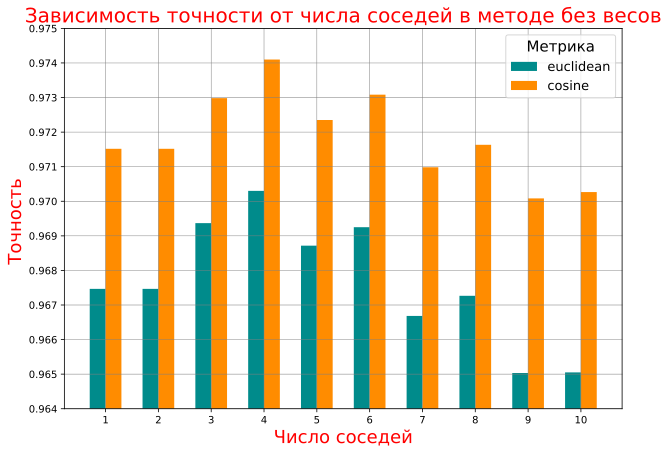

In [ ]:
pdf = PdfPages("TASK1 PRAC FIGURE 1.pdf")

fig, ax = plt.subplots(figsize=(10,7))
plt.title('Зависимость точности от числа соседей в методе без весов', color = 'r', fontsize=20)
plt.xlabel('Число соседей', color = 'r', fontsize=18)
plt.ylabel('Точность ', color = 'r', fontsize=18)
w = 0.3
neigh = np.arange(1, 11)
plt.bar(neigh - w/2, accurateness_mean['euclidean'], width=w, color='darkcyan', label='euclidean')
plt.bar(neigh + w/2, accurateness_mean['cosine'], width=w, color='darkorange', label='cosine')

plt.ylim([0.964, 0.975])
plt.yticks([0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.970, 0.971, 0.972, 0.973, 0.974, 0.975])

ax.set_xticks(np.arange(1, 11))
# ax.set_yticks(np.linspace(0.965, 0.975, num = 5))

plt.grid(which='major', color = 'grey', linewidth = 0.5)
ax.legend(title = 'Метрика', title_fontsize=15, loc=1, fontsize=13)

plt.show()
fig.savefig("TASK1 PRAC FIGURE 1.pdf", bbox_inches = 'tight')

In [ ]:
accurateness_weights = dict.fromkeys(['euclidean', 'cosine'])
time_work_weights = dict.fromkeys(['euclidean', 'cosine'])

In [ ]:
folds = 3
k = list(range(1, 11))
for i in ['euclidean', 'cosine']:
    start_time = time.time()
    ans = knn_cross_val_score(X_train, y_train, k_list=k, score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': i, 'weights': True, 'test_block_size': 1000})
    t = time.time() - start_time
    accurateness_weights[i] = ans
    time_work_weights[i] = t

In [ ]:
time_work_weights

{'euclidean': 129.8995189666748, 'cosine': 123.05615711212158}

In [ ]:
accurateness_mean_w = dict.fromkeys(['euclidean', 'cosine'])
for i in ['euclidean', 'cosine']:
    accurateness_mean_w[i] = np.ones(10)
    for j in range(10):
      accurateness_mean_w[i][j] = np.mean(accurateness_weights[i][j + 1])

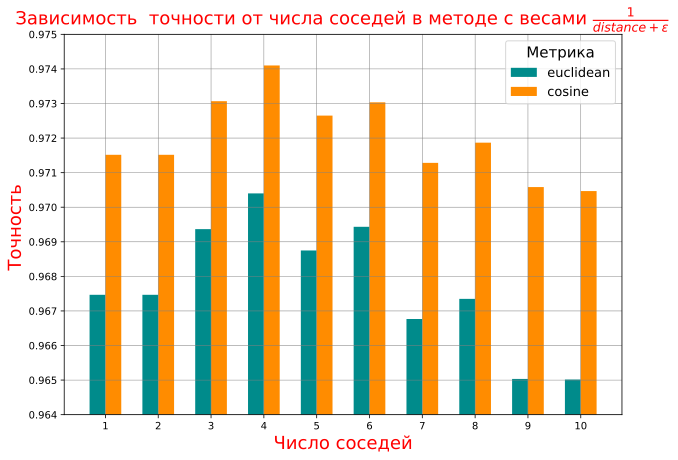

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
# plt.title('Зависимость точности от числа соседей с весами', color = 'r', fontweight = "bold", fontsize=10)
ax.set_title(r'Зависимость  точности от числа соседей в методе с весами $\frac{1}{distance + \epsilon}$',
             color = 'r', pad=10, fontsize=18)
plt.xlabel('Число соседей', color = 'r', fontsize=18)
plt.ylabel('Точность ', color = 'r', fontsize=18)
w = 0.3
neigh = np.arange(1, 11)
plt.bar(neigh - w/2, accurateness_mean_w['euclidean'], width=w, color='darkcyan', label='euclidean')
plt.bar(neigh + w/2, accurateness_mean_w['cosine'], width=w, color='darkorange', label='cosine')

plt.ylim([0.964, 0.975])
plt.yticks([0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.970, 0.971, 0.972, 0.973, 0.974, 0.975])

ax.set_xticks(np.arange(1, 11))
# ax.set_yticks(np.linspace(0.965, 0.975, num = 5))

plt.grid(which='major', color = 'grey', linewidth = 0.5)
ax.legend(title = 'Метрика', title_fontsize=15, loc=1, fontsize=13)

plt.show()
fig.savefig("TASK1 PRAC FIGURE 2.pdf", bbox_inches = 'tight')

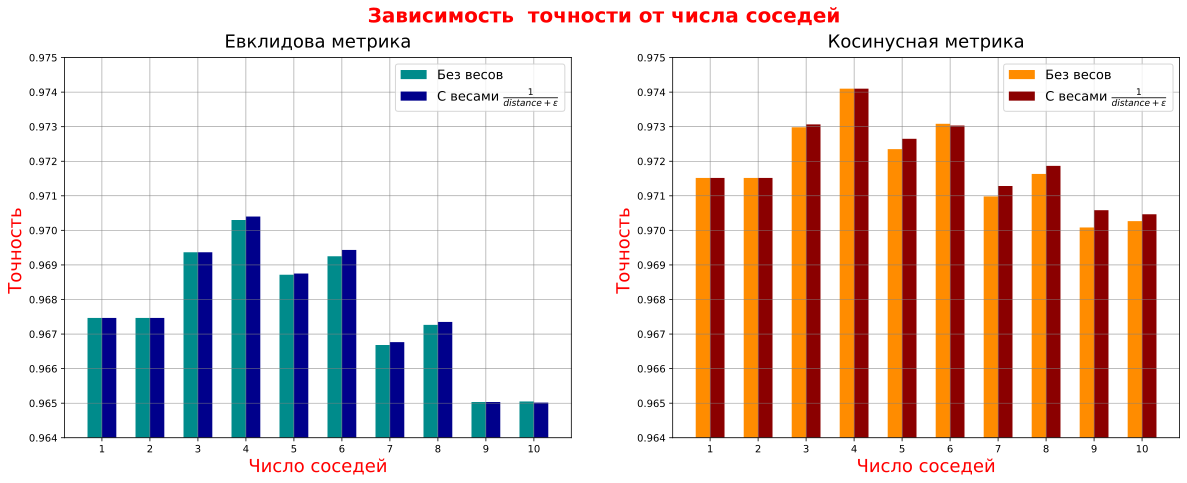

In [ ]:
from sklearn.utils import platform
fig, ax = plt.subplots(1, 2, figsize=(20,7))
w = 0.3
neigh = np.arange(1, 11)
plt.subplot(1, 2, 1)
# plt.title('Зависимость точности от числа соседей с весами', color = 'r', fontweight = "bold", fontsize=10)
plt.title(r'Евклидова метрика',
            pad=10, fontsize=18)
plt.bar(neigh - w/2, accurateness_mean['euclidean'], width=w, color ='darkcyan', label='Без весов')
plt.bar(neigh + w/2, accurateness_mean_w['euclidean'], width=w, color='darkblue', label=r'С весами $\frac{1}{distance + \epsilon}$')
plt.xticks(np.arange(1, 11))
plt.ylim([0.964, 0.975])
plt.yticks([0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.970, 0.971, 0.972, 0.973, 0.974, 0.975])
plt.legend(title_fontsize=15, loc=1, fontsize=13)
plt.xlabel('Число соседей', color = 'r', fontsize=18)
plt.ylabel('Точность ', color = 'r', fontsize=18)
plt.grid(which='major', color = 'grey', linewidth = 0.5)


plt.subplot(1, 2, 2)
plt.title('Косинусная метрика',
             pad=10, fontsize=18)
plt.bar(neigh - w/2, accurateness_mean['cosine'], width=w, color='darkorange', label='Без весов')
plt.bar(neigh + w/2, accurateness_mean_w['cosine'], width=w, color='darkred', label=r'С весами $\frac{1}{distance + \epsilon}$')
plt.ylim([0.964, 0.975])
plt.yticks([0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.970, 0.971, 0.972, 0.973, 0.974, 0.975])
plt.xticks(np.arange(1, 11))
plt.legend(title_fontsize=15, loc=1, fontsize=13)
plt.xlabel('Число соседей', color = 'r', fontsize=18)
plt.ylabel('Точность ', color = 'r', fontsize=18)
plt.grid(which='major', color = 'grey', linewidth = 0.5)


fig.suptitle('Зависимость  точности от числа соседей', 
             color = 'r',
             fontweight = "bold",
             fontsize = 20)
plt.show()
fig.savefig("TASK1 PRAC FIGURE 2-1.pdf", bbox_inches = 'tight')

In [ ]:
accurateness_mean_w['cosine']

In [ ]:
accurateness_mean['cosine']

Примените лучший алгоритм к исходной обучающей и тестовой выборке. Подсчитайте точность. Сравните с точностью по кросс-валидации. Сравните с указанной в интернете точностью лучших алгоритмов на данной выборке. Выполните анализ ошибок. Для этого необходимо построить и проанализировать матрицу ошибок (confusion matrix). Также визуализируйте несколько объектов из тестовой выборки, на которых были допущены ошибки. Проанализируйте и указажите их общие черты.

Лучше всего сработала косинусная метрика для k=4 с весами и без. Далее используем данную метрику для k=4 с весами, метод brute.

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train, y_train)
predict = classifier.predict(X_test)

In [ ]:
np.sum(predict == y_test) / len(y_test)

0.9752

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_test, predict)

In [ ]:
cm

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]])

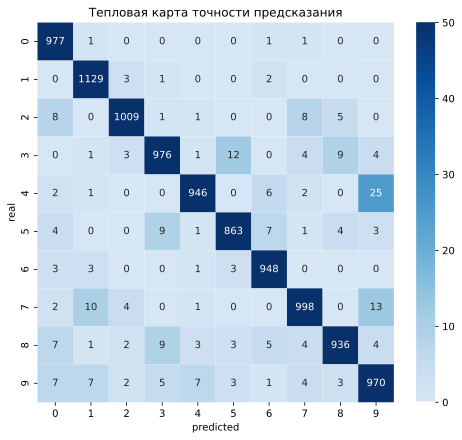

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map.pdf", bbox_inches = 'tight')

In [ ]:
import seaborn as sns
sns.heatmap(cm)

In [ ]:
cm[3][5]

12

Самая частая ошибка: реальная цифра 4 предсказалась как 9. Часто реальная цифра 9 предсказывалась неправильно. Посмотрим на первый случай

In [ ]:
plt.figure(figsize=(15, 10))

#plt.subplot(2, 2, 1)
# plt.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.binary)

plt.show()

<Figure size 1080x720 with 0 Axes>

In [ ]:
it_is9or4 = X_test[np.where((predict == 9) & (y_test == 4))]
it_is9or4.shape

(25, 784)

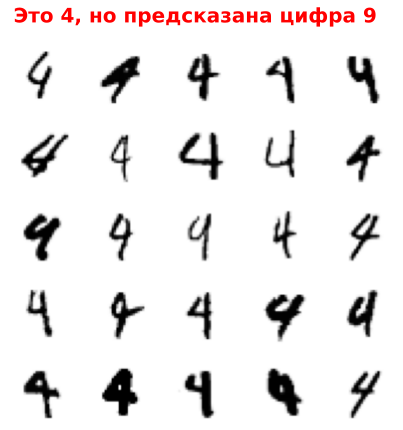

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(7,7))
k = 1
fig.suptitle('Это 4, но предсказана цифра 9', y=0.95, 
             color = 'r',
             fontweight = "bold",
             fontsize = 20)
for i in range(1, 26):
  plt.subplot(5, 5, i)
  plt.imshow(it_is9or4[i-1].reshape(28, 28), 
             cmap="Greys")
  plt.axis("off")

fig.savefig("TASK1 PRAC FIGURE 4-1.pdf", bbox_inches = 'tight')
plt.show()


Рассмотрим случай, когда реальная цифра 9 предсказана неправильно.

In [ ]:
it_is_real9 = X_test[np.where((y_test == 9) & (predict != 9))]
it_is_real9.shape

(39, 784)

In [ ]:
index_it_is_real9 = np.where((y_test == 9) & (predict != 9))
predict[index_it_is_real9]

array([8, 1, 8, 8, 4, 4, 5, 3, 3, 7, 4, 2, 6, 1, 1, 0, 4, 0, 1, 1, 1, 3,
       3, 4, 2, 0, 7, 1, 7, 4, 4, 5, 0, 3, 0, 5, 0, 0, 7])

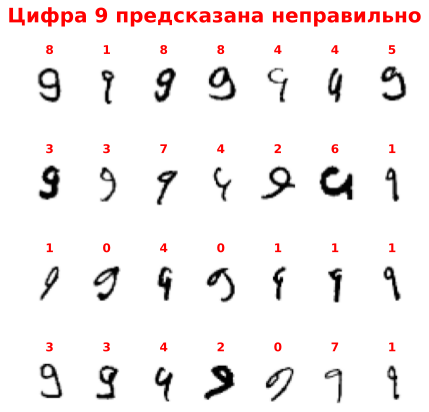

In [ ]:
fig, ax = plt.subplots(4, 7, figsize=(7,7))
k = 1
fig.suptitle('Цифра 9 предсказана неправильно', y=0.95, 
             color = 'r',
             fontweight = 'bold',
             fontsize = 20)
for i in range(1, 29):
  plt.subplot(4, 7, i)
  plt.title(predict[index_it_is_real9][i-1], color='r', fontweight = 'bold')
  plt.imshow(it_is_real9[i-1].reshape(28, 28), cmap="Greys")
  plt.axis("off")
fig.savefig("TASK1 PRAC FIGURE 4-2.pdf", bbox_inches = 'tight')
plt.show()


И выведем пару десятков случайных неправильно предсказанных цифр

In [ ]:
index_wrong_predict = y_test != predict
index_wrong_predict = np.array(np.where(index_wrong_predict == True))
ran_index = np.random.choice(np.arange(0, 248), size=50, replace=False)
index_wrong_predict = index_wrong_predict.reshape(248)
index_wrong_predict = index_wrong_predict[ran_index]
index_wrong_predict.shape

(50,)

In [ ]:
wrong_predict = X_test[index_wrong_predict]
pr = predict[index_wrong_predict]
y_pr = y_test[index_wrong_predict]

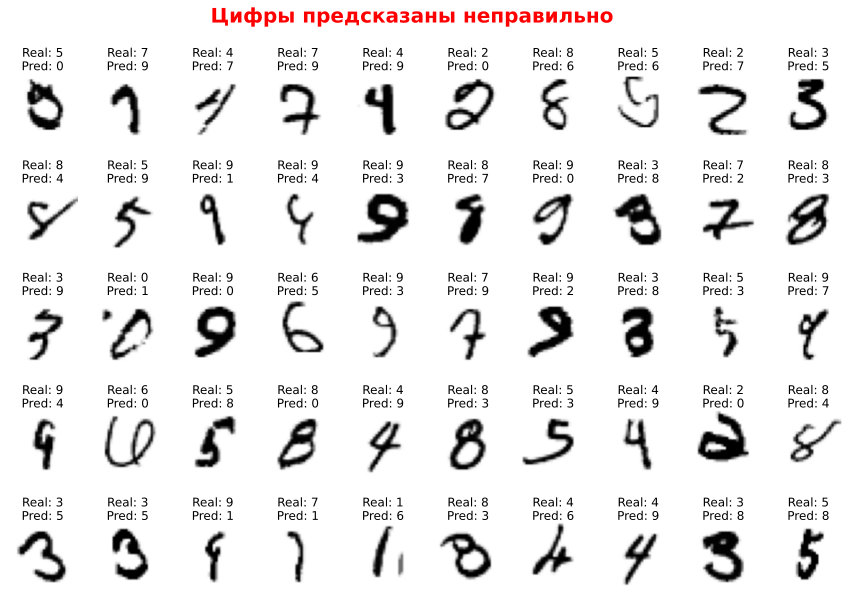

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(15,10))
fig.suptitle('Цифры предсказаны неправильно', y=0.95, 
             color = 'r',
             fontweight = "bold",
             fontsize = 20)
for i in range(1, 51):
  plt.subplot(5, 10, i)
  strin = 'Real: ' + str(y_pr[i-1])+ '\nPred: ' + str(pr[i-1])
  plt.title(strin, y=0.9)
  plt.imshow(wrong_predict[i-1].reshape(28, 28), cmap="Greys")
  plt.axis("off")

fig.savefig("TASK1 PRAC FIGURE 4-3.pdf", bbox_inches = 'tight')
plt.show()

Выполните аугментацию обучающей выборки. Для этого нужно размножить ее с помощью поворотов, смещений, морфологических операций и применений гауссовского фильтра. Разрешается использовать библиотеки для работы с изображениями. Подберите по кросс-валидации с 3 фолдами параметры преобразований. Рассмотрите следующие параметры для преобразований и их комбинации:

(a) Величина поворота: 5, 10, 15 (в каждую из двух сторон)

(b) Величина смещения: 1, 2, 3 пикселя (по каждой из двух размерностей)

(c) Дисперсия фильтра Гаусса: 0.5, 1, 1.5

(d) Морфологические операции: эрозия, дилатация, открытие, закрытие с ядром 2 

Проанализируйте, как изменилась матрица ошибок, какие ошибки алгоритма помогает исправить каждое
преобразование.

In [ ]:
u = (skimage.transform.rotate(X_train[0].reshape(28, 28), -5))

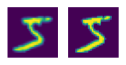

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2,2))
plt.subplot(1, 2, 1)
plt.imshow(u)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(X_train[0].reshape(28, 28))
plt.axis("off")

plt.show()

In [ ]:
X_train_rotated5_plus = np.zeros_like(X_train)
X_train_rotated5_minus = np.zeros_like(X_train)
for i in range(len(X_train)):
  X_train_rotated5_plus[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), 5)).reshape(784)
  X_train_rotated5_minus[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), -5)).reshape(784)

In [ ]:
X_train_rotated5 = np.concatenate((X_train, X_train_rotated5_plus, X_train_rotated5_minus))
y_train_rotated5 = np.concatenate((y_train, y_train, y_train))

In [ ]:
accureteness_rotated5 = knn_cross_val_score(X_train_rotated5, y_train_rotated5, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})

In [ ]:
accureteness_rotated5

{4: array([0.99346667, 0.99415   , 0.99305   ])}

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_rotated5, y_train_rotated5)
predict = classifier.predict(X_test)

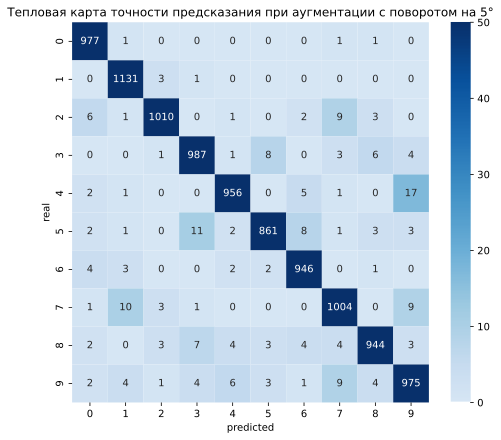

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с поворотом на 5°')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map rotated5.pdf", bbox_inches = 'tight')

In [ ]:
X_train_rotated10_plus = np.zeros_like(X_train)
X_train_rotated10_minus = np.zeros_like(X_train)
for i in range(len(X_train)):
  X_train_rotated10_plus[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), 10)).reshape(784)
  X_train_rotated10_minus[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), 10)).reshape(784)
X_train_rotated10 = np.concatenate((X_train, X_train_rotated10_plus, X_train_rotated10_minus))
y_train_rotated10 = np.concatenate((y_train, y_train, y_train))
accureteness_rotated10 = knn_cross_val_score(X_train_rotated10, y_train_rotated10, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_rotated10

{4: array([0.9911    , 0.99076667, 0.99118333])}

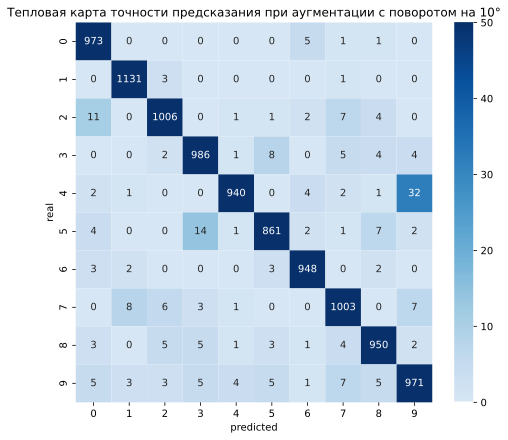

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_rotated10, y_train_rotated10)
predict = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с поворотом на 10°')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map rotated10.pdf", bbox_inches = 'tight')

In [ ]:
X_train_rotated15_plus = np.zeros_like(X_train)
X_train_rotated15_minus = np.zeros_like(X_train)
for i in range(len(X_train)):
  X_train_rotated15_plus[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), 15)).reshape(784)
  X_train_rotated15_minus[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), 15)).reshape(784)
X_train_rotated15 = np.concatenate((X_train, X_train_rotated15_plus, X_train_rotated15_minus))
y_train_rotated15 = np.concatenate((y_train, y_train, y_train))
accureteness_rotated15 = knn_cross_val_score(X_train_rotated15, y_train_rotated15, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_rotated15

{4: array([0.9873    , 0.98836667, 0.98803333])}

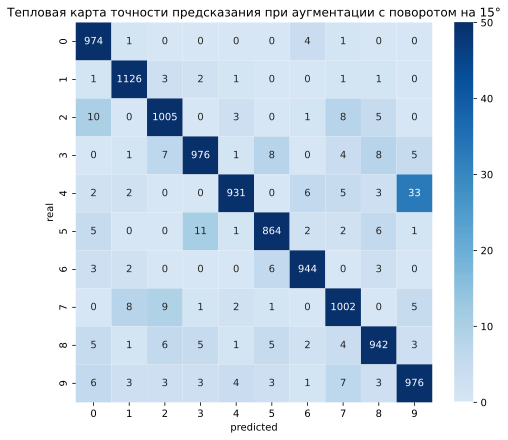

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_rotated15, y_train_rotated15)
predict = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с поворотом на 15°')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map rotated15.pdf", bbox_inches = 'tight')

In [ ]:
u = scipy.ndimage.shift(X_train[0].reshape(28, 28), [-1, 0])

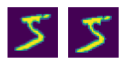

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2,2))
plt.subplot(1, 2, 1)
plt.imshow(u)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(X_train[0].reshape(28, 28))
plt.axis("off")

plt.show()

In [ ]:
(np.tile(y_train, 2)).size

120000

In [ ]:
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [1, 1])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [-1, -1])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
accureteness_shift1 = knn_cross_val_score(X_train_shift1, y_train_shift1, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_shift1

{4: array([0.97733333, 0.97705   , 0.97833333])}

In [ ]:
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [1, 0])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [-1, 0])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
accureteness_shift2 = knn_cross_val_score(X_train_shift1, y_train_shift1, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_shift2

{4: array([0.984     , 0.9841    , 0.98463333])}

In [ ]:
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [1, 0])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [0, -1])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
accureteness_shift3 = knn_cross_val_score(X_train_shift1, y_train_shift1, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_shift3

{4: array([0.98485   , 0.98391667, 0.98366667])}

In [ ]:
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [0, 1])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [0, -1])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
accureteness_shift4 = knn_cross_val_score(X_train_shift1, y_train_shift1, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_shift4

{4: array([0.9837 , 0.98445, 0.98385])}

In [ ]:
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [1, 0])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [0, 1])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
accureteness_shift5 = knn_cross_val_score(X_train_shift1, y_train_shift1, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_shift5

{4: array([0.98478333, 0.98466667, 0.98551667])}

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#отображение графиков в ноутбуке
%matplotlib inline 

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg' 

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [ ]:
k = 4
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [1, 0])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [0, 1])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_shift1, y_train_shift1)
predict = classifier.predict(X_test)

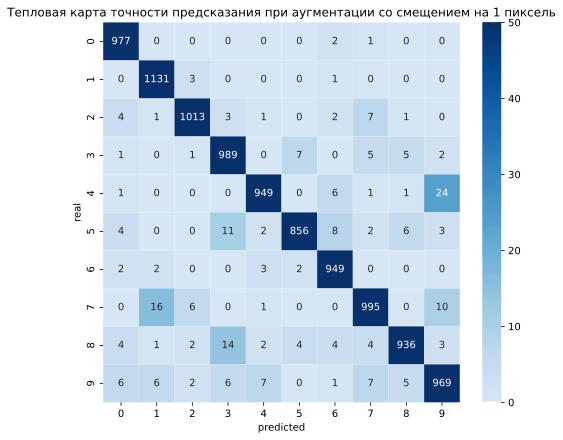

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации со смещением на 1 пиксель')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map shift1piks.pdf", bbox_inches = 'tight')

In [ ]:
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)
for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [2, 0])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [0, 2])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
accureteness_shift2_2 = knn_cross_val_score(X_train_shift1, y_train_shift1, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_shift2_2

{4: array([0.97708333, 0.97598333, 0.97681667])}

In [ ]:
k = 4
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [2, 0])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [0, 2])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_shift1, y_train_shift1)
predict = classifier.predict(X_test)

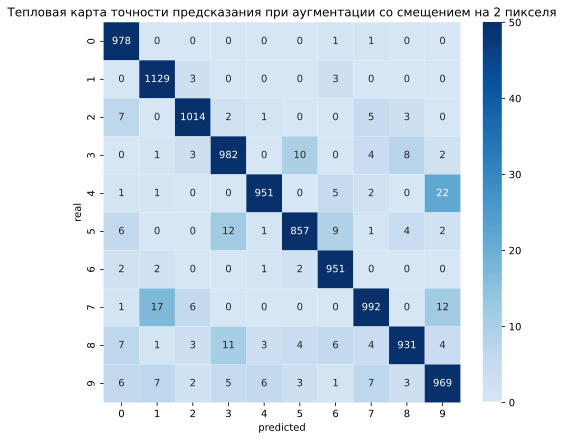

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации со смещением на 2 пикселя')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map shift2piks.pdf", bbox_inches = 'tight')

In [ ]:
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [3, 0])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [0, 3])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
accureteness_shift2_3 = knn_cross_val_score(X_train_shift1, y_train_shift1, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_shift2_3

{4: array([0.97503333, 0.9759    , 0.97646667])}

In [ ]:
k = 4
X_train_shift1_plus = np.zeros_like(X_train)
X_train_shift1_minus = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_shift1_plus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [3, 0])).reshape(784)
  X_train_shift1_minus[i] = (scipy.ndimage.shift(X_train[i].reshape(28, 28), [0, 3])).reshape(784)

X_train_shift1 = np.concatenate((X_train, X_train_shift1_plus, X_train_shift1_minus))
y_train_shift1 = np.tile(y_train, 3)
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_shift1, y_train_shift1)
predict = classifier.predict(X_test)

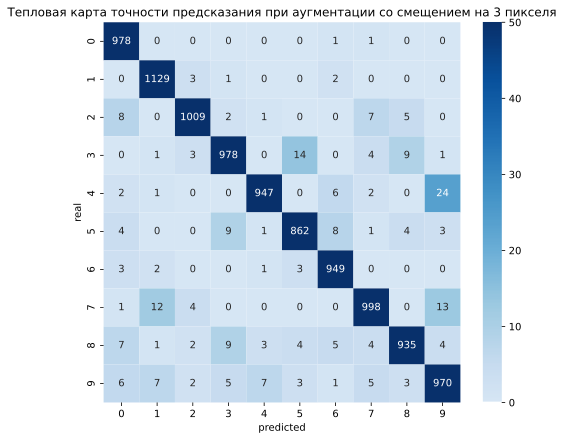

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации со смещением на 3 пикселя')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map shift3piks.pdf", bbox_inches = 'tight')

In [ ]:
import cv2 as cv

In [ ]:
u = cv.GaussianBlur(X_train[0], (25, 25), 1.5)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2,2))
plt.subplot(1, 2, 1)
plt.imshow(u.reshape(28, 28), cmap="Greys")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(X_train[0].reshape(28, 28), cmap="Greys")
plt.axis("off")

plt.show()
fig.savefig("TASK1 badgaus.pdf", bbox_inches = 'tight')

NameError: ignored

In [ ]:
X_train_filter0_5 = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_filter0_5[i] = (cv.GaussianBlur(X_train[i], (25, 25), 0.5)).reshape(784)

X_train_filter0_5 = np.concatenate((X_train, X_train_filter0_5))
y_train_filter0_5 = np.tile(y_train, 2)
accureteness_filter0_5 = knn_cross_val_score(X_train_filter0_5, y_train_filter0_5, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_filter0_5

{4: array([0.992475, 0.99295 , 0.99225 ])}

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_filter0_5, y_train_filter0_5)
predict = classifier.predict(X_test)

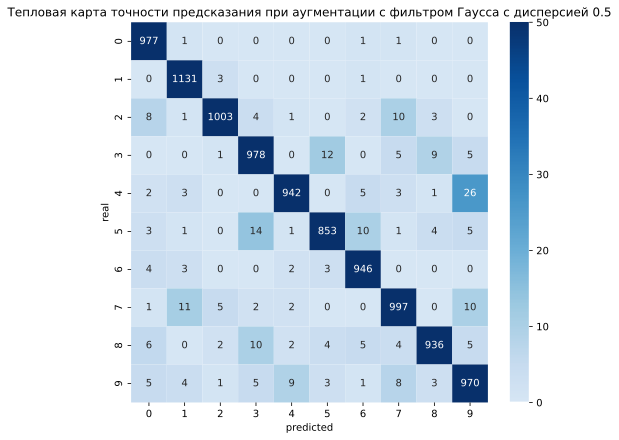

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с фильтром Гаусса с дисперсией 0.5')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map filter0_5.pdf", bbox_inches = 'tight')

In [ ]:
X_train_filter1 = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_filter1[i] = (cv.GaussianBlur(X_train[i], (25, 25), 1)).reshape(784)

X_train_filter1 = np.concatenate((X_train, X_train_filter1))
y_train_filter1 = np.tile(y_train, 2)
accureteness_filter1 = knn_cross_val_score(X_train_filter1, y_train_filter1, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_filter1

{4: array([0.9911  , 0.990725, 0.9918  ])}

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_filter1, y_train_filter1)
predict = classifier.predict(X_test)

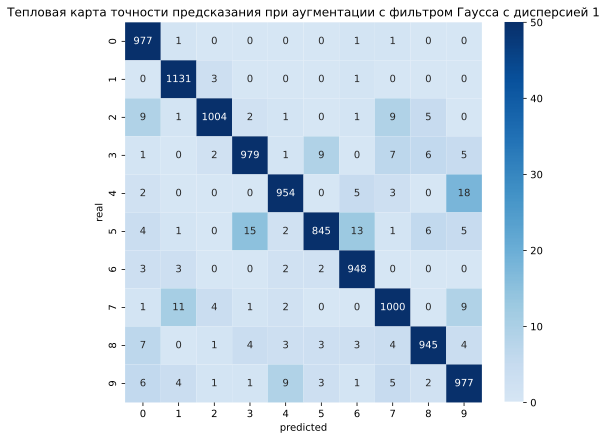

In [ ]:
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с фильтром Гаусса с дисперсией 1')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map filter1.pdf", bbox_inches = 'tight')

In [ ]:
X_train_filter1_5 = np.zeros_like(X_train)

for i in range(len(X_train)):
  X_train_filter1_5[i] = (cv.GaussianBlur(X_train[i], (25, 25), 1.5)).reshape(784)

X_train_filter1_5 = np.concatenate((X_train, X_train_filter1_5))
y_train_filter1_5 = np.tile(y_train, 2)
accureteness_filter1_5 = knn_cross_val_score(X_train_filter1_5, y_train_filter1_5, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_filter1_5

{4: array([0.9945, 0.9916, 0.9864])}

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_filter1_5, y_train_filter1_5)
predict = classifier.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с фильтром Гаусса с дисперсией 1.5')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map filter1_5.pdf", bbox_inches = 'tight')

NameError: ignored

In [ ]:
kernel = np.ones((2,2),np.uint8)
u = cv.erode(X_train[0], kernel)

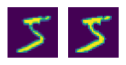

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2,2))
plt.subplot(1, 2, 1)
plt.imshow(u.reshape(28, 28))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(X_train[0].reshape(28, 28))
plt.axis("off")

plt.show()

In [ ]:
np.array_equal(u.reshape(784), X_train[0])

False

In [ ]:
X_train_erode = np.zeros_like(X_train)
kernel = np.ones((2,2),np.uint8)
for i in range(len(X_train)):
  X_train_erode[i] = (cv.erode(X_train[i], kernel)).reshape(784)

X_train_erode = np.concatenate((X_train, X_train_erode))
y_train_erode = np.tile(y_train, 2)
accureteness_erode = knn_cross_val_score(X_train_erode, y_train_erode, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_erode

{4: array([0.98525 , 0.986925, 0.986725])}

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_erode, y_train_erode)
predict = classifier.predict(X_test)

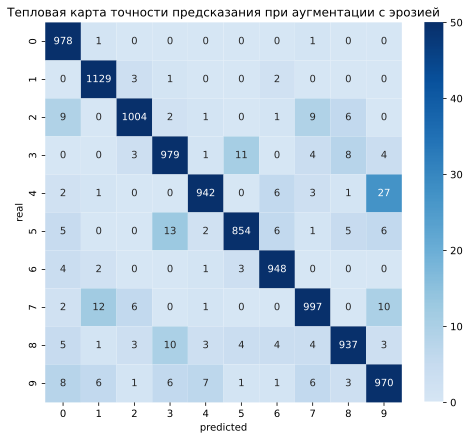

In [ ]:
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с эрозией')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map erode.pdf", bbox_inches = 'tight')

In [ ]:
kernel = np.ones((2,2),np.uint8)
u = cv.dilate(X_train[0], kernel)

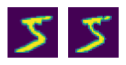

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2,2))
plt.subplot(1, 2, 1)
plt.imshow(u.reshape(28, 28))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(X_train[0].reshape(28, 28))
plt.axis("off")

plt.show()

In [ ]:
X_train_dilate = np.zeros_like(X_train)
kernel = np.ones((2,2),np.uint8)
for i in range(len(X_train)):
  X_train_dilate[i] = (cv.dilate(X_train[i], kernel)).reshape(784)

X_train_dilate = np.concatenate((X_train, X_train_dilate))
y_train_dilate = np.tile(y_train, 2)
accureteness_dilate = knn_cross_val_score(X_train_dilate, y_train_dilate, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_dilate

{4: array([0.98765 , 0.98795 , 0.987375])}

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_dilate, y_train_dilate)
predict = classifier.predict(X_test)

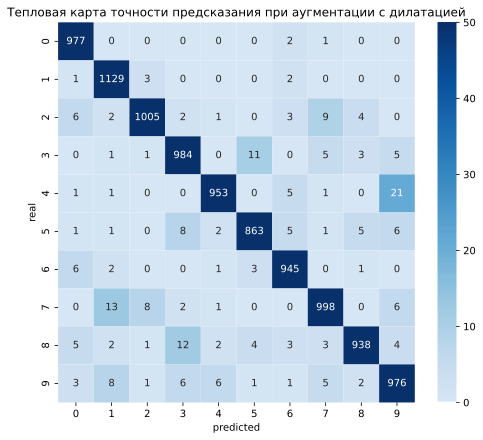

In [ ]:
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с дилатацией')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map dilate.pdf", bbox_inches = 'tight')

In [ ]:
kernel = np.ones((2,2),np.uint8)
u = cv.morphologyEx(X_train[0], cv.MORPH_OPEN, kernel)

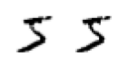

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2,2))
plt.subplot(1, 2, 1)
plt.imshow(u.reshape(28, 28), cmap="Greys")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(X_train[0].reshape(28, 28), cmap="Greys")
plt.axis("off")

plt.show()

In [ ]:
X_train_open = np.zeros_like(X_train)
kernel = np.ones((2,2),np.uint8)
for i in range(len(X_train)):
  X_train_open[i] = (cv.morphologyEx(X_train[i], cv.MORPH_OPEN, kernel)).reshape(784)

X_train_open = np.concatenate((X_train, X_train_open))
y_train_open = np.tile(y_train, 2)
accureteness_open = knn_cross_val_score(X_train_open, y_train_open, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_open

{4: array([0.981875, 0.98285 , 0.982075])}

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_open, y_train_open)
predict = classifier.predict(X_test)

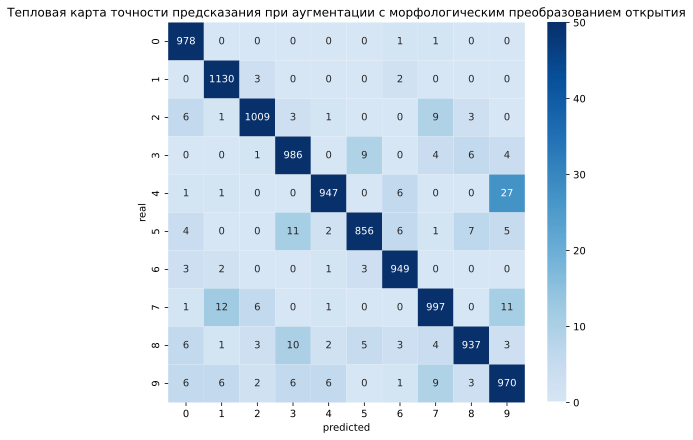

In [ ]:
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с морфологическим преобразованием открытия')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map open.pdf", bbox_inches = 'tight')

In [ ]:
X_train_close = np.zeros_like(X_train)
kernel = np.ones((2,2),np.uint8)
for i in range(len(X_train)):
  X_train_close[i] = (cv.morphologyEx(X_train[i], cv.MORPH_CLOSE, kernel)).reshape(784)

X_train_close = np.concatenate((X_train, X_train_close))
y_train_close = np.tile(y_train, 2)
accureteness_close = knn_cross_val_score(X_train_close, y_train_close, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness_close

{4: array([0.9811  , 0.982625, 0.9821  ])}

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_close, y_train_close)
predict = classifier.predict(X_test)

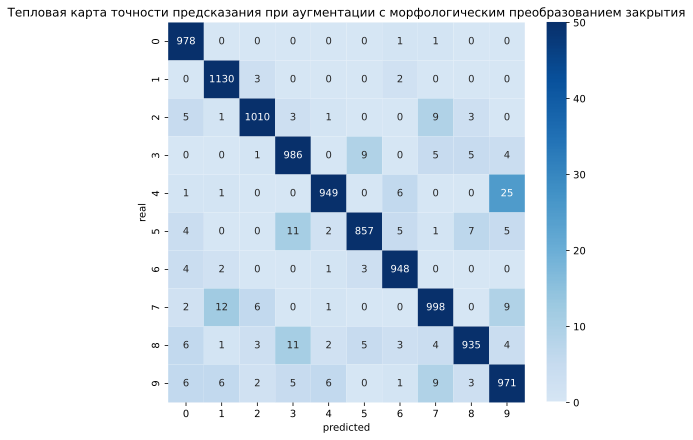

In [ ]:
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации с морфологическим преобразованием закрытия')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'Blues', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map close.pdf", bbox_inches = 'tight')

rotated5 + filter0_5

In [ ]:
import cv2 as cv
X_train_first1 = np.zeros_like(X_train)
X_train_first2 = np.zeros_like(X_train)
for i in range(len(X_train)):
  X_train_first1[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), 5)).reshape(784)
  X_train_first2[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), -5)).reshape(784)
  X_train_first1[i] = (cv.GaussianBlur(X_train_first1[i], (25, 25), 0.5)).reshape(784)
  X_train_first2[i] = (cv.GaussianBlur(X_train_first2[i], (25, 25), 0.5)).reshape(784)
X_train_first = np.concatenate((X_train, X_train_first1, X_train_first2))
y_train_first = np.tile(y_train, 3)
accureteness_first = knn_cross_val_score(X_train_first, y_train_first, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 500})
accureteness_first

{4: array([0.99321667, 0.99398333, 0.99331667])}

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=500)
classifier.fit(X_train_first, y_train_first)
predict = classifier.predict(X_test)

In [ ]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#отображение графиков в ноутбуке
%matplotlib inline 

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg' 

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

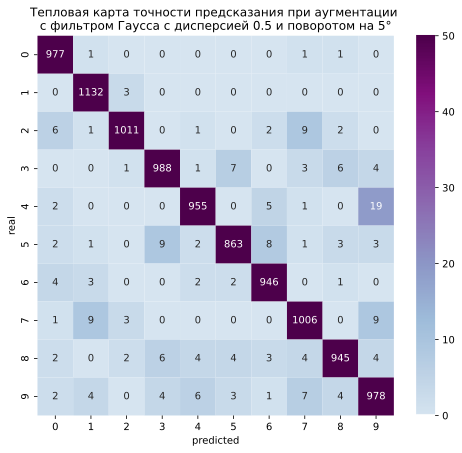

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации \nс фильтром Гаусса с дисперсией 0.5 и поворотом на 5°')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'BuPu', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map first.pdf", bbox_inches = 'tight')

In [ ]:
import random
import cv2 as cv

In [ ]:
random.randint(0, 3)

2

In [ ]:
def augment(Z, rotated=None, shift=None, gaus=None, morf=None):
  Z_augm = np.zeros_like(Z)
  if (rotated):
    for i in range(len(Z)):
      b = random.random() * (5 + 5) - 5
      Z_augm[i] = (skimage.transform.rotate(Z[i].reshape(28, 28), b)).reshape(784)
  if (shift):
    for i in range(len(Z)):
      a = random.randint(-1, 1)
      b = random.randint(-1, 1)
      Z_augm[i] = (scipy.ndimage.shift(Z[i].reshape(28, 28), [a, b])).reshape(784)
  if (gaus):
    for i in range(len(Z)):
      b = random.randint(0, 1) * 0.5
      Z_augm[i] = (cv.GaussianBlur(X_train[i], (25, 25), b)).reshape(784)
  if (morf):
    for i in range(len(Z)):
      b = random.randint(0, 3)
      kernel = np.ones((2,2),np.uint8)
      if (b == 0):
        Z_augm[i] = (cv.erode(Z[i], kernel)).reshape(784)
      elif (b == 1):
        Z_augm[i] = (cv.dilate(Z[i], kernel)).reshape(784)
      elif (b == 2):
        Z_augm[i] = (cv.morphologyEx(Z[i], cv.MORPH_OPEN, kernel)).reshape(784)
      elif (b == 3):
        Z_augm[i] = (cv.morphologyEx(Z[i], cv.MORPH_CLOSE, kernel)).reshape(784)
  return Z_augm

In [ ]:
X_train_second_1 = augment(X_train, rotated=1, gaus=1)
X_train_second_2 = augment(X_train, rotated=1, shift=1, gaus=1, morf=1)

In [ ]:
X_train_second = np.concatenate((X_train, X_train_second_1, X_train_second_2))
y_train_second = np.tile(y_train, 3)

In [ ]:
accureteness = knn_cross_val_score(X_train_second, y_train_second, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness

{4: array([0.98283333, 0.98331667, 0.98251667])}

In [ ]:
np.mean(accureteness[4])

0.9828888888888888

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_second, y_train_second)
predict = classifier.predict(X_test)

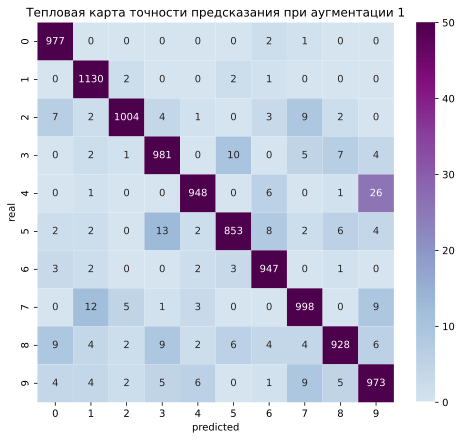

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации 1')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'BuPu', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map second_1.pdf", bbox_inches = 'tight')

In [ ]:
X_train_second_1 = augment(X_train, rotated=1, gaus=1)
X_train_second_2 = augment(X_train, shift=1, morf=1)

In [ ]:
X_train_second = np.concatenate((X_train, X_train_second_1, X_train_second_2))
y_train_second = np.tile(y_train, 3)

In [ ]:
accureteness = knn_cross_val_score(X_train_second, y_train_second, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 1000})
accureteness

{4: array([0.98323333, 0.98281667, 0.9819    ])}

In [ ]:
np.mean(accureteness[4])

0.98265

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_second, y_train_second)
predict = classifier.predict(X_test)

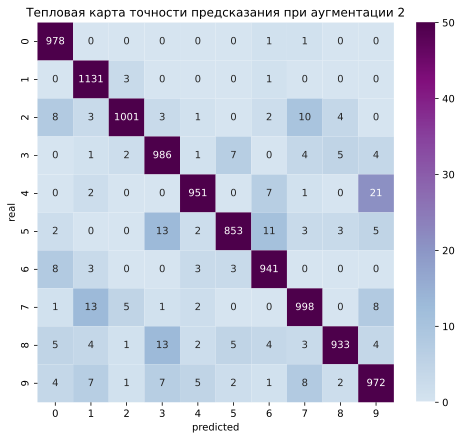

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации 2')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'BuPu', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map second_2.pdf", bbox_inches = 'tight')

In [ ]:
X_train_second_1 = augment(X_train, rotated=1, gaus=1)
X_train_second_2 = augment(X_train, rotated=1)
X_train_second = np.concatenate((X_train, X_train_second_1, X_train_second_2))
y_train_second = np.tile(y_train, 3)

In [ ]:
accureteness = knn_cross_val_score(X_train_second, y_train_second, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 500})
accureteness

{4: array([0.98778333, 0.9881    , 0.988     ])}

In [ ]:
np.mean(accureteness[4])

0.9879611111111112

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
classifier.fit(X_train_second, y_train_second)
predict = classifier.predict(X_test)

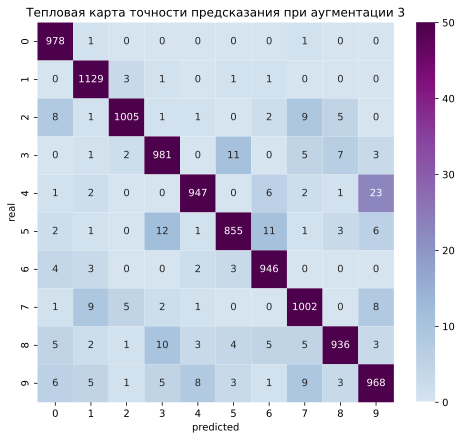

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации 3')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'BuPu', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map second_3.pdf", bbox_inches = 'tight')

Используем наш самый лучший (rotate + фильтр1) и добавим третью с полным рандомом

In [ ]:
import cv2 as cv
X_train_second1 = np.zeros_like(X_train)
X_train_second2 = np.zeros_like(X_train)
for i in range(len(X_train)):
  X_train_second1[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), 5)).reshape(784)
  X_train_second2[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), -5)).reshape(784)
  X_train_second1[i] = (cv.GaussianBlur(X_train_second1[i], (25, 25), 0.5)).reshape(784)
  X_train_second2[i] = (cv.GaussianBlur(X_train_second2[i], (25, 25), 0.5)).reshape(784)

In [ ]:
X_train_second_1 = augment(X_train, shift=1, morf=1)
X_train_second = np.concatenate((X_train, X_train_second_1, X_train_second1, X_train_second2))
y_train_second = np.tile(y_train, 4)

In [ ]:
accureteness = knn_cross_val_score(X_train_second, y_train_second, k_list=[4], score='accuracy', cv=None, 
                              **{'strategy': 'brute', 'metric': 'cosine', 'weights': True, 'test_block_size': 500})
accureteness

{4: array([0.994175 , 0.9947625, 0.9941625])}

In [ ]:
np.mean(accureteness[4])

0.9943666666666666

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=500)
classifier.fit(X_train_second, y_train_second)
predict = classifier.predict(X_test)

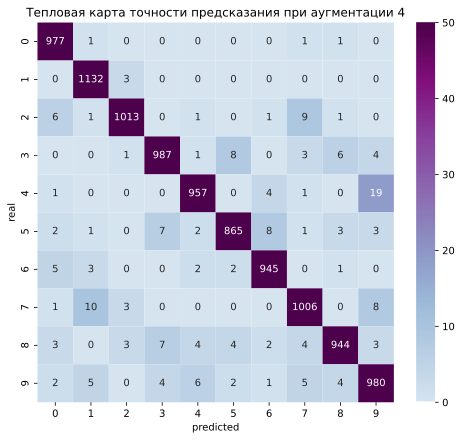

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания при аугментации 4')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'BuPu', fmt='.4g', vmin=0, vmax=50, center = 20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 warm map 4.pdf", bbox_inches = 'tight')

Реализуйте описанный выше алгоритм, основанный на преобразовании объектов тестовой выборки. Про- верьте то же самое множество параметров, что и в предыдущем пункте. Проанализируйте как изменилась матрица ошибок, какие ошибки алгоритма помогает исправить каждое преобразование. Качественно сравните два подхода (5 и 6 пункты) между собой.

In [ ]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#отображение графиков в ноутбуке
%matplotlib inline 

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg' 

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=500)
classifier.fit(X_train, y_train)

In [ ]:
X_test_rotated5 = np.zeros_like(X_test)
for i in range(len(X_test)):
  b = random.randint(0, 1)
  if b:
    X_test_rotated5[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), 5)).reshape(-1, 784)
  else:
    X_test_rotated5[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), -5)).reshape(-1, 784)

In [ ]:
X_test_rotated5.shape

(10000, 784)

In [ ]:
predict = classifier.predict(X_test_rotated5)
res = np.sum(predict == y_test) / len(y_test)
res

0.9723

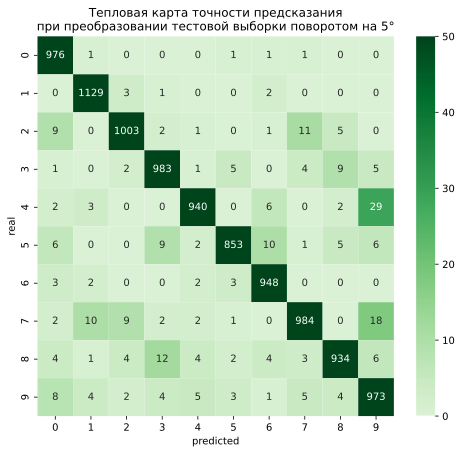

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки поворотом на 5°')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test rotated5.pdf", bbox_inches = 'tight')

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=500)
classifier.fit(X_train, y_train)

In [ ]:
X_test_rotated10 = np.zeros_like(X_test)
for i in range(len(X_test)):
  b = random.randint(0, 1)
  if b:
    X_test_rotated10[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), 10)).reshape(-1, 784)
  else:
    X_test_rotated10[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), -10)).reshape(-1, 784)

In [ ]:
predict = classifier.predict(X_test_rotated10)
res = np.sum(predict == y_test) / len(y_test)
res

0.9669

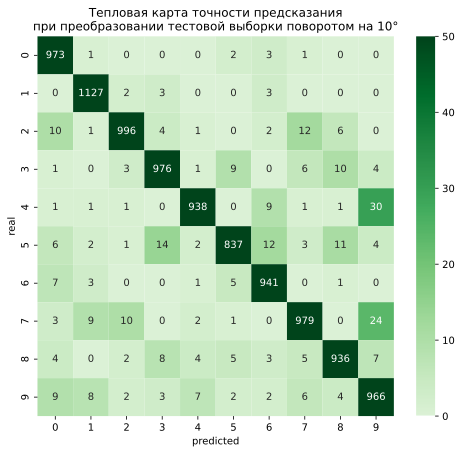

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки поворотом на 10°')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test rotated10.pdf", bbox_inches = 'tight')

In [ ]:
X_test_rotated15 = np.zeros_like(X_test)
for i in range(len(X_test)):
  b = random.randint(0, 1)
  if b:
    X_test_rotated15[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), 15)).reshape(-1, 784)
  else:
    X_test_rotated15[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), -15)).reshape(-1, 784)

In [ ]:
predict = classifier.predict(X_test_rotated15)
res = np.sum(predict == y_test) / len(y_test)
res

0.9421

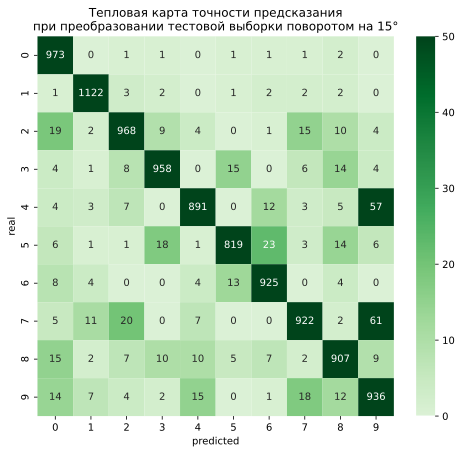

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки поворотом на 15°')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test rotated15.pdf", bbox_inches = 'tight')

In [ ]:
def vote(Z):
  prediction = np.empty(Z.shape[0], dtype=int)
  for i in range(Z.shape[0]):
    bc = np.bincount(Z[i])
    prediction[i] = bc.argmax()
  return prediction

In [ ]:
predict5 = classifier.predict(X_test_rotated5)
predict10 = classifier.predict(X_test_rotated10)
predict15 = classifier.predict(X_test_rotated15)

In [ ]:
predict5 = predict5.reshape(10000, 1)
predict10 = predict10.reshape(10000, 1)
predict15 = predict15.reshape(10000, 1)

In [ ]:
predict0 = classifier.predict(X_test)

In [ ]:
predict0 = predict0.reshape(10000, 1)

In [ ]:
predict = np.concatenate((predict0, predict5, predict10, predict15), axis=1)

In [ ]:
predict.shape

(10000, 4)

In [ ]:
predict = vote(predict)

In [ ]:
res = np.sum(predict == y_test) / len(y_test)
res

0.9661

In [ ]:
predict = vote(np.concatenate((predict5, predict10, predict15), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9574

In [ ]:
predict = vote(predict0)
res = np.sum(predict == y_test) / len(y_test)
res

0.9752

In [ ]:
predict = vote(np.concatenate((predict0, predict5, predict10), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9729

In [ ]:
X_test_rotated5_plus = np.zeros_like(X_test)
X_test_rotated5_minus = np.zeros_like(X_test)
for i in range(len(X_test)):
    X_test_rotated5_plus[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), 5)).reshape(-1, 784)
    X_test_rotated5_minus[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), -5)).reshape(-1, 784)

In [ ]:
predict5plus = classifier.predict(X_test_rotated5_plus).reshape(10000, -1)
predict5minus = classifier.predict(X_test_rotated5_minus).reshape(10000, -1)

In [ ]:
predict = vote(np.concatenate((predict0, predict5plus, predict5minus), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9763

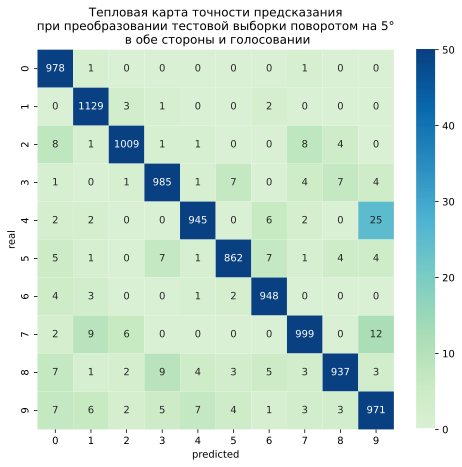

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки поворотом на 5°\n в обе стороны и голосовании')

heatmap = sns.heatmap(data=cm, annot=True, cmap='GnBu', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test 5 + - .pdf", bbox_inches = 'tight')

In [ ]:
X_test_shift1_plus = np.zeros_like(X_test)
X_test_shift1_minus = np.zeros_like(X_test)

for i in range(len(X_test)):
  X_test_shift1_plus[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [1, 0])).reshape(784)
  X_test_shift1_minus[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [0, 1])).reshape(784)

In [ ]:
predict1plus = classifier.predict(X_test_shift1_plus).reshape(10000, -1)
predict1minus = classifier.predict(X_test_shift1_minus).reshape(10000, -1)

In [ ]:
predict = vote(np.concatenate((predict0, predict1plus, predict1minus), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9712

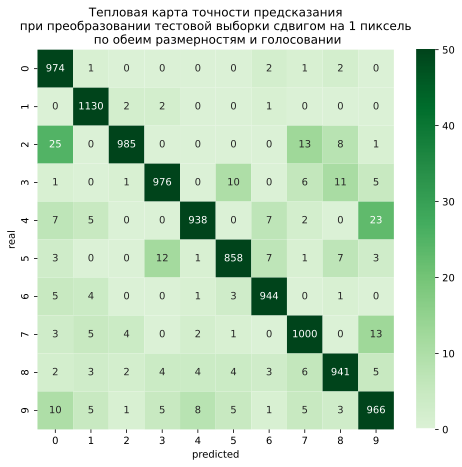

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки сдвигом на 1 пиксель\n по обеим размерностям и голосовании')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test shift 1 .pdf", bbox_inches = 'tight')

In [ ]:
X_test_shift2_plus = np.zeros_like(X_test)
X_test_shift2_minus = np.zeros_like(X_test)

for i in range(len(X_test)):
  X_test_shift2_plus[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [2, 0])).reshape(784)
  X_test_shift2_minus[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [0, 2])).reshape(784)

In [ ]:
predict2plus = classifier.predict(X_test_shift2_plus).reshape(10000, -1)
predict2minus = classifier.predict(X_test_shift2_minus).reshape(10000, -1)

In [ ]:
predict = vote(np.concatenate((predict0, predict2plus, predict2minus), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9455

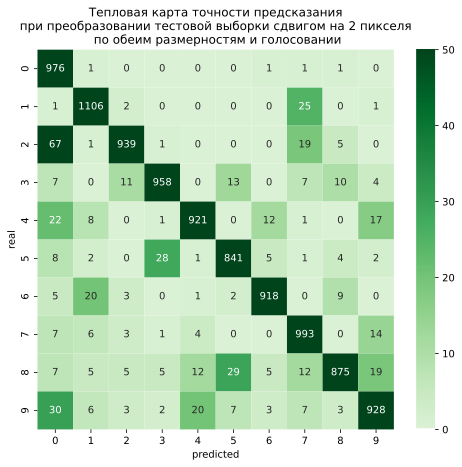

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки сдвигом на 2 пикселя\n по обеим размерностям и голосовании')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test shift 2.pdf", bbox_inches = 'tight')

In [ ]:
X_test_shift3_plus = np.zeros_like(X_test)
X_test_shift3_minus = np.zeros_like(X_test)

for i in range(len(X_test)):
  X_test_shift3_plus[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [3, 0])).reshape(784)
  X_test_shift3_minus[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [0, 3])).reshape(784)

In [ ]:
predict3plus = classifier.predict(X_test_shift3_plus).reshape(10000, -1)
predict3minus = classifier.predict(X_test_shift3_minus).reshape(10000, -1)

In [ ]:
predict = vote(np.concatenate((predict0, predict3plus, predict3minus), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.8681

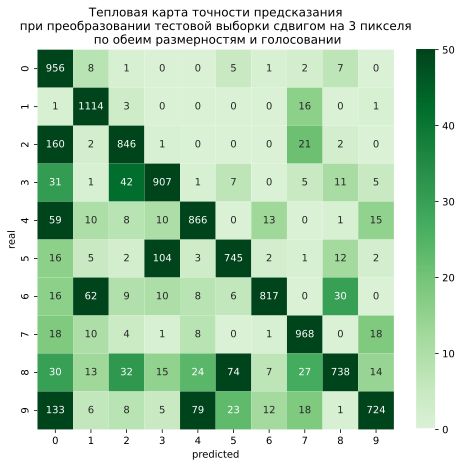

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки сдвигом на 3 пикселя\n по обеим размерностям и голосовании')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test shift 3.pdf", bbox_inches = 'tight')

Сделаем смещения на 1 во всевозможные стороны

In [ ]:
X_test_shift1_1 = np.zeros_like(X_test)
X_test_shift1_2 = np.zeros_like(X_test)
X_test_shift1_3 = np.zeros_like(X_test)
X_test_shift1_4 = np.zeros_like(X_test)

for i in range(len(X_test)):
  X_test_shift1_1[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [1, 0])).reshape(784)
  X_test_shift1_2[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [-1, 0])).reshape(784)
  X_test_shift1_3[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [0, 1])).reshape(784)
  X_test_shift1_4[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [0, -1])).reshape(784)

In [ ]:
predict1_1 = classifier.predict(X_test_shift1_1).reshape(10000, -1)
predict1_2 = classifier.predict(X_test_shift1_2).reshape(10000, -1)
predict1_3 = classifier.predict(X_test_shift1_3).reshape(10000, -1)
predict1_4 = classifier.predict(X_test_shift1_4).reshape(10000, -1)

In [ ]:
predict = vote(np.concatenate((predict0, predict1_1, predict1_2, predict1_3, predict1_4), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9761

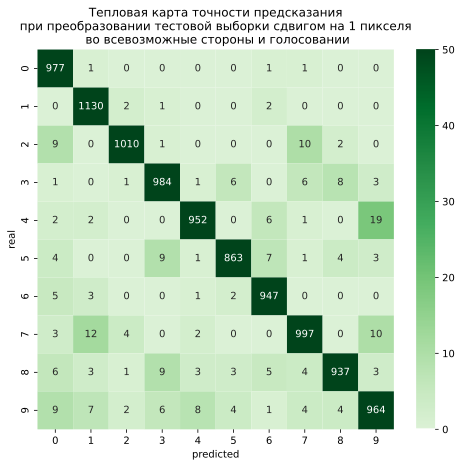

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки сдвигом на 1 пикселя\n во всевозможные стороны и голосовании')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test good shift.pdf", bbox_inches = 'tight')

In [ ]:
import cv2 as cv

In [ ]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=500)
classifier.fit(X_train, y_train)

In [ ]:
X_test_gaus05 = np.zeros_like(X_test)
X_test_gaus1 = np.zeros_like(X_test)
X_test_gaus15 = np.zeros_like(X_test)

for i in range(len(X_test)):
  X_test_gaus05[i] = (cv.GaussianBlur(X_test[i], (25, 25), 0.5)).reshape(-1, 784)
  X_test_gaus1[i] = (cv.GaussianBlur(X_test[i], (25, 25), 1)).reshape(-1, 784)
  X_test_gaus15[i] = (cv.GaussianBlur(X_test[i], (25, 25), 1.5)).reshape(-1, 784)

In [ ]:
X_test_gaus05.shape

In [ ]:
predict = classifier.predict(X_test_gaus05)
res = np.sum(predict == y_test) / len(y_test)
res

0.9742

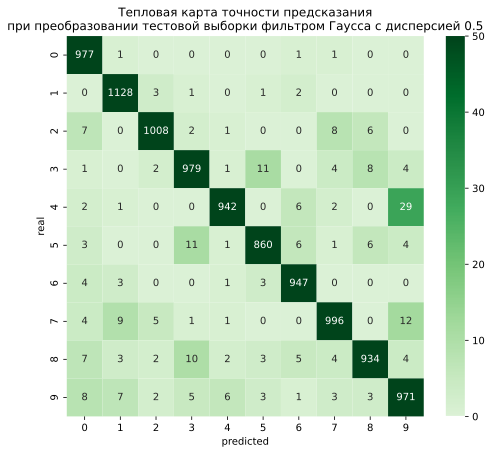

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки фильтром Гаусса с дисперсией 0.5')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test gaus05.pdf", bbox_inches = 'tight')

In [ ]:
predict = classifier.predict(X_test_gaus1)
res = np.sum(predict == y_test) / len(y_test)
res

0.9711

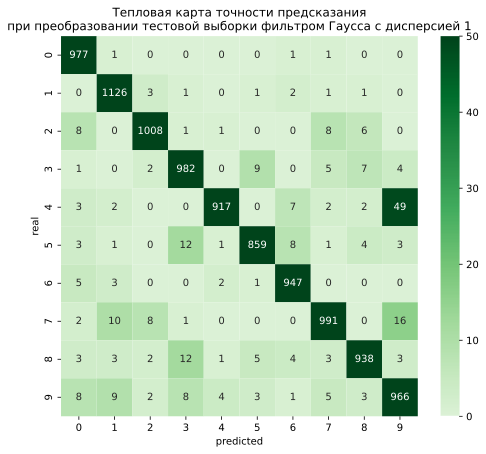

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки фильтром Гаусса с дисперсией 1')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test gaus1.pdf", bbox_inches = 'tight')

In [ ]:
predict = classifier.predict(X_test_gaus15)
res = np.sum(predict == y_test) / len(y_test)
res

0.9623

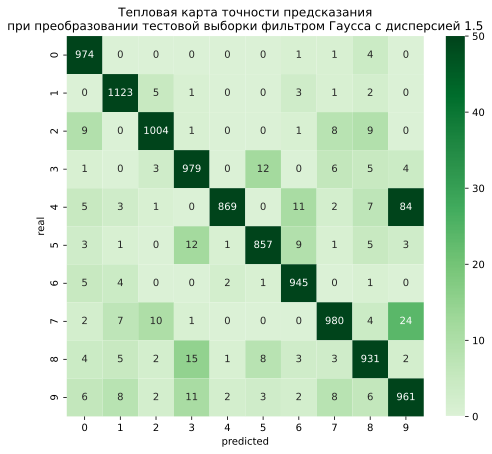

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки фильтром Гаусса с дисперсией 1.5')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test gaus15.pdf", bbox_inches = 'tight')

In [ ]:
predict1 = classifier.predict(X_test_gaus05).reshape(10000, 1)
predict2 = classifier.predict(X_test_gaus1).reshape(10000, 1)
predict0 = classifier.predict(X_test).reshape(10000, 1)

In [ ]:
predict = vote(np.concatenate((predict0, predict1, predict2), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9743

In [ ]:
kernel = np.ones((2,2),np.uint8)
X_test_morf1 = np.zeros_like(X_test)
X_test_morf2 = np.zeros_like(X_test)
X_test_morf3 = np.zeros_like(X_test)
X_test_morf4 = np.zeros_like(X_test)

for i in range(len(X_test)):
  X_test_morf1[i] = (cv.erode(X_test[i], kernel)).reshape(-1, 784)
  X_test_morf2[i] = (cv.dilate(X_test[i], kernel)).reshape(-1, 784)
  X_test_morf3[i] = (cv.morphologyEx(X_test[i], cv.MORPH_OPEN, kernel)).reshape(-1, 784)
  X_test_morf4[i] = (cv.morphologyEx(X_test[i], cv.MORPH_CLOSE, kernel)).reshape(-1, 784)

In [ ]:
predict1 = classifier.predict(X_test_morf1)
res = np.sum(predict1 == y_test) / len(y_test)
res

0.9665

In [ ]:
predict2 = classifier.predict(X_test_morf2)
res = np.sum(predict2 == y_test) / len(y_test)
res

0.9638

In [ ]:
predict3 = classifier.predict(X_test_morf3)
res = np.sum(predict3 == y_test) / len(y_test)
res

0.9475

In [ ]:
predict4 = classifier.predict(X_test_morf4)
res = np.sum(predict4 == y_test) / len(y_test)
res

0.9481

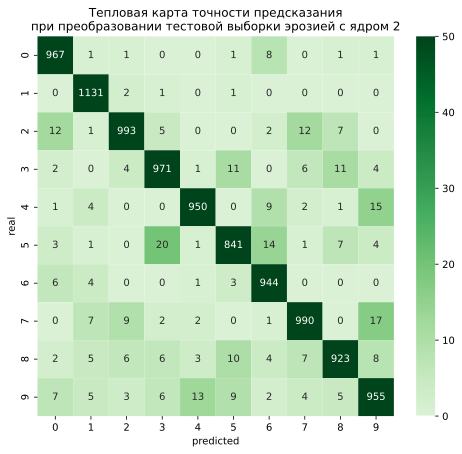

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict1)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки эрозией с ядром 2')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test morf1.pdf", bbox_inches = 'tight')

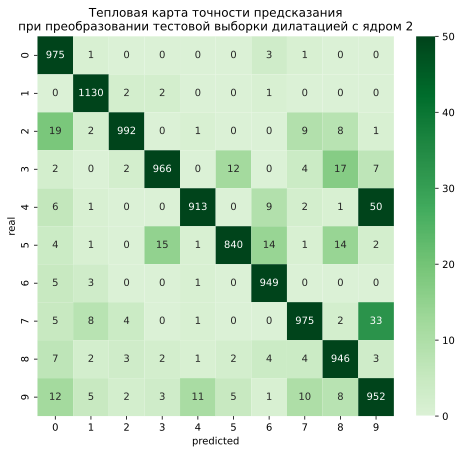

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict2)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки дилатацией с ядром 2')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test morf2.pdf", bbox_inches = 'tight')

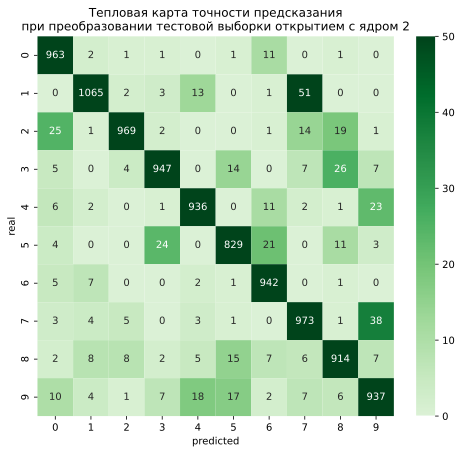

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict3)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки открытием с ядром 2')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test morf3.pdf", bbox_inches = 'tight')

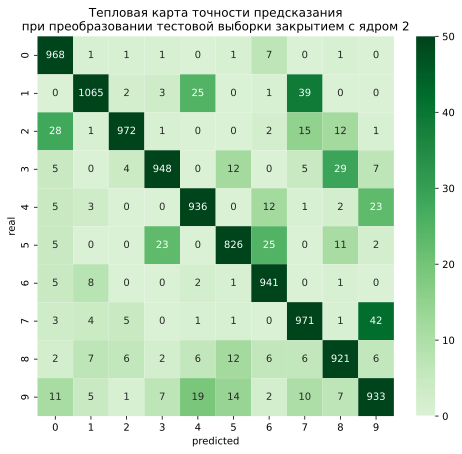

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict4)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Тепловая карта точности предсказания\nпри преобразовании тестовой выборки закрытием с ядром 2')

heatmap = sns.heatmap(data=cm, annot=True, cmap='Greens', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 test morf4.pdf", bbox_inches = 'tight')

In [ ]:
X_test_rotated5_plus = np.zeros_like(X_test)
X_test_rotated5_minus = np.zeros_like(X_test)
for i in range(len(X_test)):
    X_test_rotated5_plus[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), 5)).reshape(-1, 784)
    X_test_rotated5_minus[i] = (skimage.transform.rotate(X_test[i].reshape(28, 28), -5)).reshape(-1, 784)

In [ ]:
predict5plus = classifier.predict(X_test_rotated5_plus).reshape(10000, -1)
predict5minus = classifier.predict(X_test_rotated5_minus).reshape(10000, -1)

In [ ]:
X_test_shift1_1 = np.zeros_like(X_test)
X_test_shift1_2 = np.zeros_like(X_test)
X_test_shift1_3 = np.zeros_like(X_test)
X_test_shift1_4 = np.zeros_like(X_test)

for i in range(len(X_test)):
  X_test_shift1_1[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [1, 0])).reshape(784)
  X_test_shift1_2[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [-1, 0])).reshape(784)
  X_test_shift1_3[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [0, 1])).reshape(784)
  X_test_shift1_4[i] = (scipy.ndimage.shift(X_test[i].reshape(28, 28), [0, -1])).reshape(784)

In [ ]:
predict1_1 = classifier.predict(X_test_shift1_1).reshape(10000, -1)
predict1_2 = classifier.predict(X_test_shift1_2).reshape(10000, -1)
predict1_3 = classifier.predict(X_test_shift1_3).reshape(10000, -1)
predict1_4 = classifier.predict(X_test_shift1_4).reshape(10000, -1)

In [ ]:
predict = vote(np.concatenate((predict0, predict5plus, predict5minus, predict1_1, predict1_2, predict1_3, predict1_4), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9763

In [ ]:
predict1 = vote(np.concatenate((predict0, predict5plus, predict5minus), axis=1)).reshape(10000, 1)

In [ ]:
predict2 = vote(np.concatenate((predict0, predict1_1, predict1_2, predict1_3, predict1_4), axis=1)).reshape(10000, 1)

In [ ]:
predict1.shape.reshape(10000, 1)

(10000,)

In [ ]:
predict = vote(np.concatenate((predict0, predict1, predict2), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9763

In [23]:
import cv2 as cv
X_train_second1 = np.zeros_like(X_train)
X_train_second2 = np.zeros_like(X_train)
for i in range(len(X_train)):
  X_train_second1[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), 5)).reshape(784)
  X_train_second2[i] = (skimage.transform.rotate(X_train[i].reshape(28, 28), -5)).reshape(784)
  X_train_second1[i] = (cv.GaussianBlur(X_train_second1[i], (25, 25), 0.5)).reshape(784)
  X_train_second2[i] = (cv.GaussianBlur(X_train_second2[i], (25, 25), 0.5)).reshape(784)

In [24]:
#@title
def augment(Z, rotated=None, shift=None, gaus=None, morf=None):
  Z_augm = np.zeros_like(Z)
  if (rotated):
    for i in range(len(Z)):
      b = random.random() * (5 + 5) - 5
      Z_augm[i] = (skimage.transform.rotate(Z[i].reshape(28, 28), b)).reshape(784)
  if (shift):
    for i in range(len(Z)):
      a = random.randint(-1, 1)
      b = random.randint(-1, 1)
      Z_augm[i] = (scipy.ndimage.shift(Z[i].reshape(28, 28), [a, b])).reshape(784)
  if (gaus):
    for i in range(len(Z)):
      b = random.randint(0, 1) * 0.5
      Z_augm[i] = (cv.GaussianBlur(X_train[i], (25, 25), b)).reshape(784)
  if (morf):
    for i in range(len(Z)):
      b = random.randint(0, 3)
      kernel = np.ones((2,2),np.uint8)
      if (b == 0):
        Z_augm[i] = (cv.erode(Z[i], kernel)).reshape(784)
      elif (b == 1):
        Z_augm[i] = (cv.dilate(Z[i], kernel)).reshape(784)
      elif (b == 2):
        Z_augm[i] = (cv.morphologyEx(Z[i], cv.MORPH_OPEN, kernel)).reshape(784)
      elif (b == 3):
        Z_augm[i] = (cv.morphologyEx(Z[i], cv.MORPH_CLOSE, kernel)).reshape(784)
  return Z_augm

In [25]:
#@title
import random
import cv2 as cv

In [26]:
X_train_second_1 = augment(X_train, shift=1, morf=1)
X_train_second = np.concatenate((X_train, X_train_second_1, X_train_second1, X_train_second2))
y_train_second = np.tile(y_train, 4)

In [27]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=500)
classifier.fit(X_train_second, y_train_second)

In [28]:
import time
start_time = time.time()
predict0 = classifier.predict(X_test).reshape(10000, -1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 183.0176899433136 seconds ---


In [29]:
k = 4
classifier = KNNClassifier(k, strategy='brute', metric='cosine', weights=True, test_block_size=500)
classifier.fit(X_train, y_train)

In [30]:
import time
start_time = time.time()
predict0 = classifier.predict(X_test).reshape(10000, -1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 50.621992111206055 seconds ---


In [ ]:
predict5plus = classifier.predict(X_test_rotated5_plus).reshape(10000, -1)
predict5minus = classifier.predict(X_test_rotated5_minus).reshape(10000, -1)
predict1_1 = classifier.predict(X_test_shift1_1).reshape(10000, -1)
predict1_2 = classifier.predict(X_test_shift1_2).reshape(10000, -1)
predict1_3 = classifier.predict(X_test_shift1_3).reshape(10000, -1)
predict1_4 = classifier.predict(X_test_shift1_4).reshape(10000, -1)
predict0 = classifier.predict(X_test).reshape(10000, -1)

In [ ]:
predict = vote(np.concatenate((predict0, predict5plus, predict5minus, predict1_1, predict1_2, predict1_3, predict1_4), axis=1))
res = np.sum(predict == y_test) / len(y_test)
res

0.9823

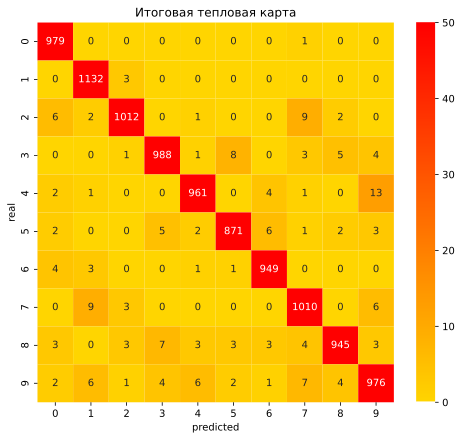

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predict)
fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Итоговая тепловая карта')

heatmap = sns.heatmap(data=cm, annot=True, cmap= 'autumn_r', fmt='.4g', vmin=0, vmax=50, center=20)
heatmap.set(xlabel = 'predicted', ylabel = 'real')
plt.show()
fig.savefig("TASK1 end.pdf", bbox_inches = 'tight')

In [ ]:
predict = vote(predict0)
res = np.sum(predict == y_test) / len(y_test)
res

0.9809

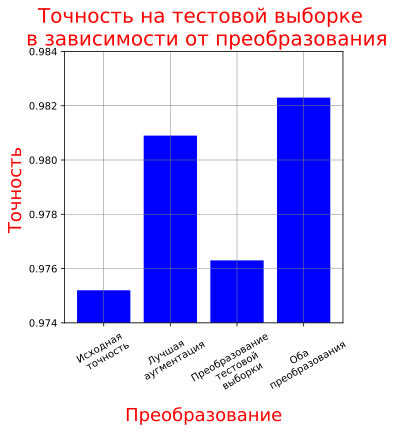

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Точность на тестовой выборке \n в зависимости от преобразования', color = 'r', fontsize=20)
plt.xlabel('Преобразование', color = 'r', fontsize=18)
plt.ylabel('Точность ', color = 'r', fontsize=18)

neigh = ['Исходная \n точность', 'Лучшая \n аугментация', 'Преобразование \n тестовой \nвыборки', 'Оба \n преобразования']
plt.bar(neigh, [0.9752, 0.9809, 0.9763, 0.9823], color='blue')
# plt.bar(neigh, accurateness_mean['cosine'], color='darkorange', label='cosine')

plt.ylim([0.974, 0.984])
#plt.yticks([0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.970, 0.971, 0.972, 0.973, 0.974, 0.975])
plt.xticks(rotation=30)
#ax.set_xticks(np.arange(1, 11))
# ax.set_yticks(np.linspace(0.965, 0.975, num = 5))

plt.grid(which='major', color = 'grey', linewidth = 0.5)

plt.show()
fig.savefig("TASK1 PRAC сравнение.pdf", bbox_inches = 'tight')